In [1]:
#!/usr/bin/python


from __future__ import print_function
import pandas
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from scipy.optimize import NonlinearConstraint, LinearConstraint
from scipy.optimize import BFGS, minimize, Bounds, SR1
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
import numpy
from keras.models import model_from_json, load_model
from pathlib import Path
import os.path
import time
import os
import math
import pyipopt
from numpy import *
from tensorflow.keras.layers import Dense
from deel.lip.activations import GroupSort
from tensorflow import keras
import tensorflow as tf
from keras.layers import AbstractRNNCell
from deel.lip.layers import (
    SpectralDense,
    SpectralConv2D,
    ScaledL2NormPooling2D,
    FrobeniusDense,
)
from tensorflow.keras.layers import Dense
from deel.lip.activations import GroupSort
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2023-02-08 18:30:54.420953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:30:54.624884: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 18:30:54.725896: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-08 18:30:55.339723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
####################defining constants in the CSTR ################
#####Simulation time step
t_final=1e-3
t_step=1e-5 #delta/100
short_factor=int(t_final/t_step) 
T_0 = 300.0
Vol = 1.0
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000.0
Q_s = 0.0
F = 5.0
E = 5.0*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4.0
C_As= 1.9537
T_s=  401.8727
P = np.array([[0.52,  22], [22, 1060]])
setpoint=[0.0, 0.0]
u_min = np.array([-3.5, -500000]) +  np.array([C_A0s, Q_s])
u_max = np.array([3.5, 500000]) +  np.array([C_A0s, Q_s])

#########################



In [3]:
####################### simulation settings ##############
####Initial states
Ti=72
CAi=-1.65
x1_nn=Ti
x2_nn=CAi 
x1_record=[Ti]
x2_record=[CAi]
u1_record=[]
u2_record=[]
realtime_data=[Ti,CAi]
#### simulation setting constants ####
NUM_MPC_ITERATION=300   # MPC TOTAL ITERATION
NUM_OUTPUTS=2  ###### dimension of outputs
NUM_INPUTS=2 ##### inputs per horizon 
NUM_HORIZON=2 ## MPC PREDICTION HORIZON
NUM_MPC_INPUTS=NUM_INPUTS*NUM_HORIZON ##
NUM_MPC_CONSTRAINTS=NUM_HORIZON




In [4]:
#### function we are trying to approximate####
#### we use x_dot = f(x) + g(x) u ############
#### we return vectors in shape (n,), otherwise we use (n,m) shape all inputs are not in vector form for clarity

def f(T,C_A):
    f1 = F / Vol * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 
    f2 = F / Vol * (- C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
    f1s = F / Vol * (T_0 - T_s) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T_s)) * C_As**2
    f2s = F / Vol * (- C_As) - k_0 * np.exp(-E / (R * T_s)) * C_As**2
    return np.array([f1-f1s,f2-f2s])


def g(T,C_A):
    return np.array([[0, 1/ (rho_L * C_p * Vol)],[F / Vol , 0]])




def V(T,C_A):
    x = np.array([T-T_s,  C_A-C_As])
    return x @ P @ x


def dV_dx(T,C_A):
    x = np.array([T-T_s,  C_A-C_As])
    return 2 *  x @ P 



def LfV(T,C_A):
    return dV_dx(T,C_A) @ f(T,C_A)


def LgV(T,C_A):
    return (dV_dx(T,C_A) @ g(T,C_A)) [1]




def sontag(T,C_A):
    phi = np.array([0.0,0.0])
    a =  LfV(T,C_A)
    b =  LgV(T,C_A)
    if np.linalg.norm(b)**2  < 1e-12:
        return phi
    factor = - (a + np.sqrt(a**2 + b**4)) / (b**2) 
    for i in range(1,len(u_min)):
        psi_i  =  factor * b
        if psi_i < u_min[i]:
            phi[i] = u_min[i]
        elif psi_i > u_max[i]:
            phi[i] = u_max[i]
        else:
            phi[i] = psi_i
    return phi

def prof_sontag(T,C_A):
    Td2 = T-T_s
    CAd2 = C_A-C_As
    a=1060
    b=22
    d=0.52  # Lyapunov function V=x^T*P*x
    LfV = (2 * a * CAd2 + 2 * b * Td2) * ((F / Vol) * (-CAd2) - k_0 * ((numpy.exp(-E / (R * (Td2 + T_s))) * (CAd2 + C_As) ** 2)-
                                                                        numpy.exp(-E / (R * T_s)) *(C_As)**2)) + \
              (2 * d * Td2 + 2 * b * CAd2) * (((F / Vol) * (-Td2) + (-delta_H / (rho_L* C_p)) *
                                               (k_0 * ((numpy.exp(-E / (R * (Td2 + T_s))) *(CAd2 + C_As) ** 2) - numpy.exp(-E / (R * T_s)) * C_As ** 2))))

        #LfV= dV/dx * f
    print("prof LFV" , LfV)

    LgV = (2 * d * Td2 + 2 * b * CAd2) / (Vol * rho_L * C_p)  #LgV= dV/dx * g

    print("prof LGV" , LgV)
 
    h2x = -(LfV + sqrt((LfV ** 2) + LgV ** 4)) / (LgV)
    return h2x  #



### note: the T_in and C_A_in are the current states, NOT in deviation form #### 
def dx_dt(T, C_A, C_A0,  Q):
    u = np.array([C_A0,  Q]).reshape(2,)
    g_times_u = np.matmul(g(T,C_A), u)
    dTdt = f(T,C_A)[0] + g_times_u[0]
    dCAdt = f(T,C_A)[1] + g_times_u[1]
    return np.array([dTdt, dCAdt])





###### states and controls are now in deviation form. also we use (x,u) , state variable first then control action. ##############################
def CSTR_simulation(T_initial , C_A_initial , C_A0,  Q):
    """
        simulating CSTR using forward Euler method
    """
    
    C_A = C_A_initial + C_As
    T = T_initial + T_s
    
    for i in range(int(t_final / t_step)):
        gradient = dx_dt(T, C_A, C_A0,  Q)
        dTdt = gradient[0]
        dCAdt = gradient[1]
        C_A += dCAdt * t_step  # in deviation form
        T += dTdt * t_step  
    
    return  np.array([T-T_s , C_A-C_As])



########################output is now in deviation form ######################


##### test case for sanity check ########

print(realtime_data)
T_test = Ti + T_s + 5
C_test = CAi + C_As + 1
print(T_test,C_test)
print("f", f(T_s,C_As))
print("total", f(T_s,C_As) + g(T_s,C_As) @ (0,0))

print("f", f(T_test,C_test))
print("g", g(T_test,C_test))
print("V", V(T_test,C_test))
print("dV_dx", dV_dx(T_test,C_test))
print("LfV", LfV(T_test,C_test))
print("LgV" , LgV(T_test,C_test))
print("sontag", sontag(T_test,C_test))
print("sontag", prof_sontag(T_test,C_test) )


print(realtime_data)
T_test = 34.46551490119333 + T_s 
C_test = -0.7019464724746394 + C_As 
print(T_test,C_test)
print("f", f(T_s,C_As))
print("total", f(T_s,C_As) + g(T_s,C_As) @ (0,0))

print("f", f(T_test,C_test))
print("g", g(T_test,C_test))
print("V", V(T_test,C_test))
print("dV_dx", dV_dx(T_test,C_test))
print("LfV", LfV(T_test,C_test))
print("LgV" , LgV(T_test,C_test))
print("sontag", sontag(T_test,C_test))
print("sontag", prof_sontag(T_test,C_test) )



[72, -1.65]
478.8727 1.3037
f [0. 0.]
total [0. 0.]
f [1621.55367735  -37.05555648]
g [[0.00000000e+00 4.32900433e-03]
 [5.00000000e+00 0.00000000e+00]]
V 1328.7300000000002
dV_dx [  51.48 2010.  ]
LfV 8995.914794275232
LgV 0.22285714285714286
sontag [     0.         -80732.56866719]
prof LFV 8995.914794275217
prof LGV 0.22285714285714286
sontag -80732.56866718765
[72, -1.65]
436.33821490119334 1.2517535275253606
f [0. 0.]
total [0. 0.]
f [0.18519812 0.0444758 ]
g [[0.00000000e+00 4.32900433e-03]
 [5.00000000e+00 0.00000000e+00]]
V 75.49622357879214
dV_dx [ 4.95849071 28.35613401]
LfV 2.179464859049485
LgV 0.02146532774180489
sontag [   0.         -203.06840032]
prof LFV 2.179464859049717
prof LGV 0.02146532774180489
sontag -203.068400316796


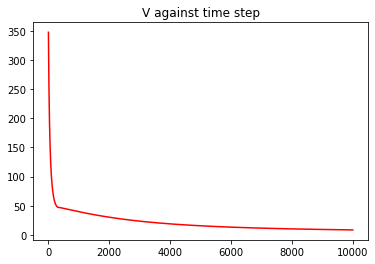

8.538342213352454


In [5]:

realtime_data_fake=[Ti,CAi]
n = 10000
V_record_fake = []
for i in range(n):
    controller = sontag(realtime_data_fake[0]+ T_s, realtime_data_fake[1] + C_As)
    realtime_data_fake = CSTR_simulation(realtime_data_fake[0], realtime_data_fake[1] , controller[0],  controller[1])
    V_record_fake.append(V(realtime_data_fake[0]+ T_s, realtime_data_fake[1] + C_As))

x = np.array([i for i in range(1,n+1)])
y = np.array(V_record_fake)
plt.title("V against time step")
plt.plot(x, y, color="red")
plt.show()

    

print(V_record_fake[-1])


In [6]:
########## import data from your scalers into the code. You need to know the means and standard variations of your scalers. ####
######## note that the input and output scalers for states (x) are not the same ########

import numpy as np
with open('meanandvar.npy', 'rb') as filename:
    scaler_X_mean = np.load(filename)
    scaler_X_std = np.load(filename)
    scaler_y_mean = np.load(filename)
    scaler_y_std = np.load(filename)

 
u1_mean,u2_mean ,x1_mean, x2_mean = scaler_X_mean[0],scaler_X_mean[1],scaler_X_mean[2],scaler_X_mean[3]
u1_std,u2_std, x1_std, x2_std, = scaler_X_std[0],scaler_X_std[1],scaler_X_std[2],scaler_X_std[3]
y1_mean, y2_mean = scaler_y_mean[0], scaler_y_mean[1]
y1_std, y2_std = scaler_y_std[0], scaler_y_std[1]
state_mean=numpy.array([x2_mean , x1_mean])
state_std=numpy.array([x2_std , x1_std])
input_mean=numpy.array([u1_mean, u2_mean])
input_std=numpy.array([u1_std, u2_std])
output_mean=numpy.array([y2_mean, y1_mean])
output_std=numpy.array([y2_std, y1_std])

print(state_mean)
print(state_std)
print(input_mean)
print(input_std)
print(output_mean)
print(output_std)

[-0.11549729  0.00452658]
[38.2902928   0.84973792]
[ 1.73157895e-03 -1.87969925e+02]
[2.12486774e+00 3.03533870e+05]
[-0.18121829  0.00583368]
[38.29335314  0.84752101]


In [7]:
###### state is your current state (T,C_A) ##########
#####  inputs are in (C_A0,Q) * number of horizons.
#### e.g if number of horizons is 2, then its (C_A01,Q1,C_A02,Q2)
title = "Dense , Hidden Layers : [640, 640] noise : 0.1.h5"
model = tf.keras.models.load_model(title)
def my_ens_prediction(num_horizon, state ,my_inputs):
    assert len(my_inputs) == NUM_INPUTS * num_horizon 
    ensemble_output = np.zeros( (num_horizon, len(state) ) ) ##### store the trajectory here
    T = state[0]
    C_A = state[1]
    for i in range(num_horizon):
        curr_state = np.array([T,C_A])
        state_normalized = (curr_state - state_mean)/state_std
        inputs = my_inputs[2*i : 2*i + 2]
        inputs_normalized = (inputs - input_mean)/input_std        
        new_state_normalized = model.predict(np.array([inputs_normalized[0],  inputs_normalized[1], state_normalized[1] , state_normalized[0]]).reshape((1,4)), verbose = 0) 
         ##### go to the next time step
        new_state_normalized = np.flip(new_state_normalized,1)
        new_state = new_state_normalized * output_std + output_mean
        ensemble_output[i] = new_state
        T = new_state[0,0]
        C_A = new_state[0,1] 
    return ensemble_output




2023-02-08 18:31:10.166670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:31:10.903787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22568 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [8]:
#### eval_ function, whose value depends on the MPC Control inputs ###
def eval_loss(my_inputs):
    assert len(my_inputs) == NUM_INPUTS * NUM_HORIZON
    loss = 0
    my_inputs_actual = my_inputs.copy()
    for i in range(len(my_inputs)):
        if i % 2 == 1:
            my_inputs_actual[i] = my_inputs[i] * 1e5
    my_inputs = my_inputs_actual
    ensemble_output = my_ens_prediction(NUM_HORIZON, realtime_data ,my_inputs)
    for i in range(NUM_HORIZON):
        """
        loss += ( 1/state_std[0] * (setpoint[0] - ensemble_output[i,0]) ) ** 2 + ( 1/state_std[1] * (setpoint[1] - ensemble_output[i,1]) ) ** 2
        """
        loss += ( 1/40.0 * (setpoint[0] - ensemble_output[i,0]) ) ** 2 + ( 1/1.0 * (setpoint[1] - ensemble_output[i,1]) ) ** 2
        loss += ( ( ( 1/10 * my_inputs[2*i] ) ** 2 + ( 1/500000 * my_inputs[2*i + 1] ) ** 2 ))
    return loss

##### test case for sanity check ########

def eval_grad_loss(my_inputs):  ## gradient of objective function
    assert len(my_inputs) == int(NUM_MPC_INPUTS)
    step = 1e-3
    grad = [0]*NUM_MPC_INPUTS
    for i_mpc_input in range(NUM_MPC_INPUTS):
        x_forward  = my_inputs.copy()
        x_backward = my_inputs.copy()
        # for each variables, we need to evaluate the derivative of the function with respect to that variable, This is why we have the for loop
        x_forward[i_mpc_input]  = x_forward[i_mpc_input]  + step 
        x_backward[i_mpc_input] = x_backward[i_mpc_input] - step
        objf=eval_loss(x_forward) # This function returns the value of the objective function evaluated with the variable x[i] is perturebed +step
        objb=eval_loss(x_backward) # This function returns the value of the objective function evaluated with the variable x[i] is perturebed -step
        grad[i_mpc_input] = (objf - objb) / (2 * step) # This evaluates the gradient of the objetive function with repect to the optimization variable
        if math.isnan(grad[i_mpc_input]) or math.isinf(grad[i_mpc_input]):
            print("Here")
    return np.array(grad)

##### test case for sanity check ########


def eval_constraint(my_inputs):
    ##### note : indicator should be thought of as a boolean array. if all elements > 0, the input is feasiable. Else , return False.  
    assert len(my_inputs) == NUM_INPUTS * NUM_HORIZON
    my_inputs_actual = my_inputs.copy()
    for i in range(len(my_inputs)):
        if i % 2 == 1:
            my_inputs_actual[i] = my_inputs[i] * 1e5
    my_inputs = my_inputs_actual
    num_horizon = int(len(my_inputs) / 2)
    indicator = np.array([0.0] * num_horizon)
    T = realtime_data[0] + T_s
    C_A = realtime_data[1] + C_As
    if V(T,C_A) > 2: #### if V >= rho-nn = 2 ####
        """
        dV_dt = dV_dx(T,C_A) @ dx_dt(T, C_A, my_inputs[0], my_inputs[1])### only first set of inputs 
        dV_dt_sontag = dV_dx(T,C_A) @ dx_dt(T, C_A, sontag(T,C_A)[0] , sontag(T,C_A)[1])
        indicator[0] = dV_dt - dV_dt_sontag 
        """
        sontag_output = my_ens_prediction(1, realtime_data , sontag(T,C_A))[0]
        ensemble_output = my_ens_prediction(1, realtime_data , my_inputs[0:2])[0]
        indicator[0] = V(ensemble_output[0]+ T_s,ensemble_output[1] + C_As)  - V(sontag_output[0]+ T_s, sontag_output[1] + C_As)

    else:
        ensemble_output = my_ens_prediction(num_horizon, realtime_data, my_inputs)
        for i in range(num_horizon):
            future_state = ensemble_output[i]
            indicator[i] = - float(2.0) + V(future_state[0]+ T_s,future_state[1] + C_As)
    return indicator



def eval_jac_constraint(my_inputs, flag):
    if flag:
        list_x = []
        list_y=[]
        for i in range(int(NUM_MPC_INPUTS / 2)):
            list_x = list_x + [i] * NUM_MPC_INPUTS
            list_y = list_y +list(range(0, int(NUM_MPC_INPUTS)))
        return (array(list_x),
                array(list_y))
    else:
        assert len(my_inputs) == int(NUM_MPC_INPUTS)
        step = 1e-3
        gp=gm=numpy.zeros(NUM_MPC_CONSTRAINTS)
        xpstep=xmstep=numpy.zeros(NUM_MPC_INPUTS)
        jac_g = [[0]*int(NUM_MPC_INPUTS) for _ in range(NUM_MPC_CONSTRAINTS)]
        for i_mpc_input in range(NUM_MPC_INPUTS):
            xpstep=my_inputs.copy()
            xmstep=my_inputs.copy()
            xpstep[i_mpc_input] += step 
            xmstep[i_mpc_input] -= step
            gp=eval_constraint(xpstep)
            gm=eval_constraint(xmstep)
            for num_constraint in range(NUM_MPC_CONSTRAINTS):
                jac_g[num_constraint][i_mpc_input] = (gp[num_constraint] - gm[num_constraint]) / (2 * step)
                if math.isnan(jac_g[num_constraint][i_mpc_input]) or math.isinf(jac_g[num_constraint][i_mpc_input]):
                    print("Here2")
        return array(jac_g)






        



In [9]:
input_0 = array([0.0]*int(NUM_MPC_INPUTS))
T = realtime_data[0] + T_s
C_A = realtime_data[1] + C_As
input_0[1] = sontag(T,C_A)[1]/1e5
print(input_0)
sontag_output = my_ens_prediction(1, realtime_data , sontag(T,C_A))[0]
V_sontag = V(sontag_output[0]+ T_s, sontag_output[1] + C_As)
print(sontag_output, V_sontag)

[ 0. -0.  0.  0.]
[69.45479407 -1.57606017] 325.0100560295241


In [10]:
import pyipopt
import json


Ti=72
CAi=-1.65 

nnzh = NUM_MPC_INPUTS**2 ## non-zero elements in Hessian matrix
nnzj = NUM_MPC_CONSTRAINTS*NUM_MPC_INPUTS ## non-zero elements in acobian matrix
ncon = NUM_MPC_CONSTRAINTS

####################################################################
##### SOLVING THE MPC PROGRAM TO FIND THE OPTIMIZED MPC INPUTS #####
####################################################################
##########  KEEP RUNNING MPC ###############

dir_name = os.getcwd()
test = os.listdir(dir_name)
results_dict = dict()
for item in test:
    if item.endswith(".txt"):
        os.remove(os.path.join(dir_name, item))



nvar = NUM_MPC_INPUTS

##  DEFINE THE UPPER BOUND AND LOWER BOUND FOR optimized variables ###
input_lower=[0]* nvar
input_upper=[0]* nvar
for i in range(int(NUM_MPC_INPUTS/2)):
    input_lower[2*i]= -3.5 
    input_lower[2 * i+1] = -5
    input_upper[2 * i] = 3.5  
    input_upper[2 * i + 1] = 5
input_L = array(input_lower) 
input_U = array(input_upper)


### DEFINE THE UPPER BOUND AND LOWER BOUND OF THE CONSTRAINT ###
with open('Dense NN MPC Results 030223') as json_file:
    results_dict = json.load(json_file)

constraint_L = array([-2e19]*NUM_HORIZON)
constraint_U = array([0]*NUM_HORIZON)

print("Previous Simulations Completed" , len(results_dict['V_record']))


while len(results_dict['V_record'])<300:
    if  len(results_dict['V_record']) == 0:
        realtime_data=numpy.array([Ti, CAi])
    else:
        realtime_data=numpy.array([results_dict['x1_record'][-1], results_dict['x2_record'][-1]])
        
    print ("Num Iteratin: ", len(results_dict['V_record']))

    nlp = pyipopt.create(nvar, input_L, input_U, ncon, constraint_L, constraint_U, nnzj, nnzh, eval_loss, eval_grad_loss, eval_constraint, eval_jac_constraint)


    input_0 = array([0.0]*int(NUM_MPC_INPUTS))
    T = realtime_data[0] + T_s
    C_A = realtime_data[1] + C_As
    input_0[1] = sontag(T,C_A)[1]/1e5
    
    sontag_output = my_ens_prediction(1, realtime_data , sontag(T,C_A))[0]
    V_sontag = V(sontag_output[0]+ T_s, sontag_output[1] + C_As)
    print("Lyapunov function for Sontag Controller:" + str(V_sontag))

    





    nlp.int_option('max_iter', 500)
    nlp.num_option('tol', 1e-3)
    nlp.int_option('print_level', 2)
    print("Going to call solve")
    print("input_0  = {}".format(input_0))
    input_opt , zl, zu, constraint_multipliers, obj, status = nlp.solve(input_0)

    nlp.close()

    print("Solution of the primal variables,input_opt")
    print("input_opt", input_opt)


    print("Objective value")
    print("loss(x*) = {}".format(obj))
    print ("Control action=:  ", input_opt[0], input_opt[1])
    print("Status : " + str(status))


    

    realtime_data = CSTR_simulation(realtime_data[0] , realtime_data[1] , input_opt[0],  input_opt[1] * 1e5 )



    print('Real model output x1 x2 in deviation form:   ', realtime_data[0], realtime_data[1])
    print("Lyapunov function now :" + str(V(realtime_data[0]+ T_s,realtime_data[1] + C_As) ))

    results_dict["x1_record"].append(realtime_data[0])
    results_dict["x2_record"].append(realtime_data[1])
    results_dict["u1_record"].append(input_opt[0])
    results_dict["u2_record"].append(input_opt[1])
    results_dict['V_record'].append(V(realtime_data[0]+ T_s,realtime_data[1] + C_As))

    with open('Dense NN MPC Results 030223', 'w')  as fp:
        json.dump(results_dict,fp) 


print ("x1_record: ",results_dict["x1_record"])
print ("x2_record: ",results_dict["x2_record"])

print ("u1_record: ",results_dict["u1_record"])
print ("u2_record: ",results_dict["u2_record"])

print("Vrecord:" , results_dict['V_record'])






#
numpy.savetxt("x1.txt",   x1_record, fmt="%f",  delimiter=" ")
numpy.savetxt("x2.txt",   x2_record, fmt="%f",  delimiter=" ")


numpy.savetxt("u1.txt",   u1_record, fmt="%f",  delimiter=" ")
numpy.savetxt("u2.txt",   u2_record, fmt="%f",  delimiter=" ")


Previous Simulations Completed 262
Num Iteratin:  262
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
Lyapunov function for Sontag Controller:5.755876149383521
Going to call solve
input_0  = [0.00000000e+00 6.07099103e-14 0.00000000e+00 0.00000000e+00]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Solution of the primal variables,input_opt
input_opt [-1.63775552  1.11374108  0.58971578  0.10703102]
Objective value
loss(x*) = 0.08647870974818953
Control action=:   -1.637755523917289 1.113741084281195
Status : 0
Real model output x1 x2 in deviation form:    4.168363604434944 -0.13450993801171718
Lyapunov function now :3.543432